<a href="https://colab.research.google.com/github/jaredlan1/getting_started_with_ML/blob/main/HW3_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Create a figure similar to Fig A6: the top contour plot (but you don’t need all the x’s marking data locations) and the rightmost graph that shows a slice through the data at t=0.75 (you just need your prediction, don’t need to plot “exact”). I used Nu=100 and Nf=10,000. You’ll likely find that you get pretty good prediction but the shock wave isn’t captured as well (rounded instead of sharp). That’s sufficient for the purpose of this assignment, but if you’re interested in improving that, see the advanced tips below the regular tips.

In this case the problem is very small, so the number of data and collocation points provides super high coverage everywhere we are making predictions at. So while creating separate train/test datasets is still, in general, very important, in this particular problem a separate testing set won’t be needed (again for larger problems you should definitely have a test set).

A few tips:

Use a tanh activation function like noted in the paper (or some other continuously differentiable activation function) since we need second derivatives of the neural net.
When computing derivatives with torch.autograd.grad you will need to use the grad outputs option. We have vectors x and t going in, and vector u coming out, where each element of the vectors corresponds to a different data sample. In other words, dui/dxi and dui/dti are independent of every other index i. To compute all these derivatives in one shot, pass a vector of ones in the grad outputs option (i.e., grad outputs = torch.ones_like(x)). This is called the “seed” for algorithmic differentiation.
You also need to set create_graph=True in the call to torch.autograd.grad since we will need to backpropgate through these derivatives (i.e., compute derivatives of derivatives)
It’s fine to just use Adam for this assignment, even though they mention LBFGS (see advanced tips if interested in the latter).
Latin hypercube sampling is helpful for the collocation points to get good coverage. You can use from scipy.stats import qmc. Though I’m sure you could do fine for this small problem with just regular random sampling or even sampling. Either way, be sure that these sampling points stay fixed during the training.
As with any neural net problem, I’d recommend starting with a smaller number of layers, collocation points, and epochs until things seem to be working properly, then scale up.
Optional advanced tips if you want to really capture that shock:

Change everything to double precision. There are large derivatives near the shock and the accuracy isn’t good enough with single precision. For any torch tensor you create you need to set dtype=torch.float64 and for the network you need to change all its weights and biases to double precision also: model.double() where model is your instantiated network.
Use the LBFGS optimizer with the strong wolfe line search option (line_search_fn="strong_wolfe"). In the optimization world, we always use second-order methods like BFGS. But they are not compatible with minibatching and so the DL world almost always uses first-order methods. In this case we don’t have tons of data, so we don’t need minibatching, and the second-order optimizer will do much better. It will be much slower per epoch, but you’ll also need way less epochs. LBFGS with a line search is setup to work differently and you will need to create a closure function when you call optimizer.step(closure). It’s essentially the same as the train function. Search online or use AI chatbots for examples. In this case you’ll want to set optimizer.zero_grad() at the beginning of the closure function. Adam and all the other optimizers work with closure functions too, they just don’t require it.

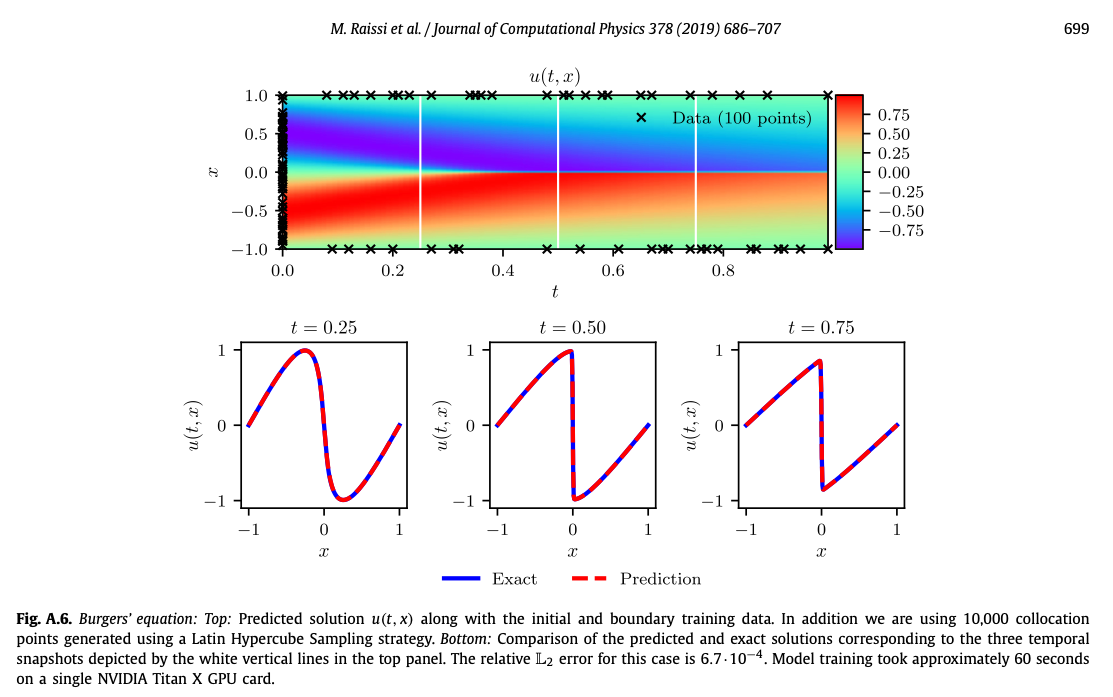

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.stats import qmc

np.random.seed(0)
torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [10]:
# Cell 2 — Problem setup + training data (Nu=100) + collocation points (Nf=10,000)
# Domain: x ∈ [-1, 1], t ∈ [0, 1]
# Viscous Burgers: u_t + u u_x - nu u_xx = 0
nu = 0.01 / np.pi
N_u = 100
N_f = 10_000

# Initial condition: u(0,x) = -sin(pi x)
N_ic = 50
x_ic = np.linspace(-1, 1, N_ic)[:, None]
t_ic = np.zeros_like(x_ic)
u_ic = -np.sin(np.pi * x_ic)

# Boundary condition: u(t, -1) = u(t, 1) = 0
N_bc = N_u - N_ic
t_bc = np.random.rand(N_bc, 1)
x_bc = np.vstack([
    -np.ones((N_bc // 2, 1)),
    np.ones((N_bc - N_bc // 2, 1))
])
t_bc = np.vstack([t_bc[:N_bc // 2], t_bc[N_bc // 2:]])
u_bc = np.zeros_like(x_bc)

# Supervised set (IC + BC)
x_u = np.vstack([x_ic, x_bc])
t_u = np.vstack([t_ic, t_bc])
u_u = np.vstack([u_ic, u_bc])

# Collocation points via Latin Hypercube Sampling (fixed set!)
sampler = qmc.LatinHypercube(d=2, seed=0)
X_f = sampler.random(n=N_f)
x_f = 2.0 * X_f[:, [0]] - 1.0   # scale to [-1, 1]
t_f = X_f[:, [1]]              # already [0, 1]

def to_tensor(a, requires_grad=False, dtype=torch.float32):
    return torch.tensor(a, dtype=dtype, device=device, requires_grad=requires_grad)

x_u_t = to_tensor(x_u, requires_grad=True)
t_u_t = to_tensor(t_u, requires_grad=True)
u_u_t = to_tensor(u_u, requires_grad=False)

# store collocation as non-grad tensors; we'll enable grads per minibatch
x_f_all = to_tensor(x_f, requires_grad=False)
t_f_all = to_tensor(t_f, requires_grad=False)

print("x_u_t:", x_u_t.shape, "t_u_t:", t_u_t.shape, "u_u_t:", u_u_t.shape)
print("x_f_all:", x_f_all.shape, "t_f_all:", t_f_all.shape)


x_bc : [[-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]]
x_u_t: torch.Size([100, 1]) t_u_t: torch.Size([100, 1]) u_u_t: torch.Size([100, 1])
x_f_all: torch.Size([10000, 1]) t_f_all: torch.Size([10000, 1])


In [5]:
# Cell 3 — Define the PINN model (tanh MLP) + Xavier init
class PINN(torch.nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(torch.nn.Linear(layers[i], layers[i+1]))

        # Xavier init
        for m in self.layers:
            torch.nn.init.xavier_normal_(m.weight)
            torch.nn.init.zeros_(m.bias)

    def forward(self, x, t):
        z = torch.cat([x, t], dim=1)
        for i, layer in enumerate(self.layers):
            z = layer(z)
            if i < len(self.layers) - 1:
                z = torch.tanh(z)
        return z

# A reasonable small network for the assignment (fast enough)
model = PINN([2, 64, 64, 64, 64, 1]).to(device)
print(model)


PINN(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1-3): 3 x Linear(in_features=64, out_features=64, bias=True)
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [6]:
# Cell 4 — PDE residual using autograd (u_t + u u_x - nu u_xx)
def burgers_residual(x, t):
    """
    x, t: tensors shaped (N,1) with requires_grad=True
    returns: residual f shaped (N,1)
    """
    u = model(x, t)
    ones = torch.ones_like(u)

    u_t = torch.autograd.grad(
        u, t, grad_outputs=ones, create_graph=True, retain_graph=True
    )[0]

    u_x = torch.autograd.grad(
        u, x, grad_outputs=ones, create_graph=True, retain_graph=True
    )[0]

    u_xx = torch.autograd.grad(
        u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True, retain_graph=True
    )[0]

    f = u_t + u * u_x - nu * u_xx
    return f


In [7]:
# Cell 5 — Training loop (Adam). Collocation minibatch (but fixed collocation set).
lr = 1e-3
epochs = 5000
batch_f = 2000  # collocation minibatch size; increase if you have GPU time

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for ep in range(1, epochs + 1):
    optimizer.zero_grad(set_to_none=True)

    # Supervised loss (IC + BC)
    u_pred = model(x_u_t, t_u_t)
    loss_u = torch.mean((u_pred - u_u_t) ** 2)

    # Physics loss (minibatch from fixed LHS set)
    idx = torch.randint(0, N_f, (batch_f,), device=device)
    x_f_b = x_f_all[idx].clone().detach().requires_grad_(True)
    t_f_b = t_f_all[idx].clone().detach().requires_grad_(True)

    f_pred = burgers_residual(x_f_b, t_f_b)
    loss_f = torch.mean(f_pred ** 2)

    loss = loss_u + loss_f
    loss.backward()
    optimizer.step()

    if ep % 500 == 0 or ep == 1:
        print(f"epoch {ep:5d} | loss {loss.item():.3e} | loss_u {loss_u.item():.3e} | loss_f {loss_f.item():.3e}")


epoch     1 | loss 3.880e-01 | loss_u 3.301e-01 | loss_f 5.786e-02
epoch   500 | loss 6.461e-02 | loss_u 4.842e-02 | loss_f 1.619e-02
epoch  1000 | loss 5.084e-02 | loss_u 3.710e-02 | loss_f 1.373e-02
epoch  1500 | loss 4.948e-02 | loss_u 3.790e-02 | loss_f 1.158e-02
epoch  2000 | loss 4.465e-02 | loss_u 3.244e-02 | loss_f 1.222e-02
epoch  2500 | loss 3.499e-02 | loss_u 2.273e-02 | loss_f 1.226e-02
epoch  3000 | loss 2.030e-02 | loss_u 1.316e-02 | loss_f 7.143e-03
epoch  3500 | loss 1.642e-02 | loss_u 1.302e-02 | loss_f 3.396e-03
epoch  4000 | loss 1.039e-02 | loss_u 6.900e-03 | loss_f 3.492e-03
epoch  4500 | loss 9.988e-03 | loss_u 6.746e-03 | loss_f 3.243e-03
epoch  5000 | loss 5.303e-03 | loss_u 3.449e-03 | loss_f 1.854e-03


In [8]:
# Cell 6 — Build prediction grid for contour plot + slice at t=0.75
model.eval()

nx, nt = 256, 101
xg = np.linspace(-1, 1, nx)
tg = np.linspace(0, 1, nt)

T, X = np.meshgrid(tg, xg)  # shapes (nx, nt)

with torch.no_grad():
    X_t = to_tensor(X.reshape(-1, 1), requires_grad=False)
    T_t = to_tensor(T.reshape(-1, 1), requires_grad=False)
    U_pred = model(X_t, T_t).detach().cpu().numpy().reshape(nx, nt)

# Slice at t=0.75
t_slice = 0.75
with torch.no_grad():
    x_slice_t = to_tensor(xg[:, None], requires_grad=False)
    t_slice_t = to_tensor((t_slice * np.ones((nx, 1))), requires_grad=False)
    u_slice_pred = model(x_slice_t, t_slice_t).detach().cpu().numpy().ravel()

print("U_pred:", U_pred.shape, "u_slice_pred:", u_slice_pred.shape)


U_pred: (256, 101) u_slice_pred: (256,)


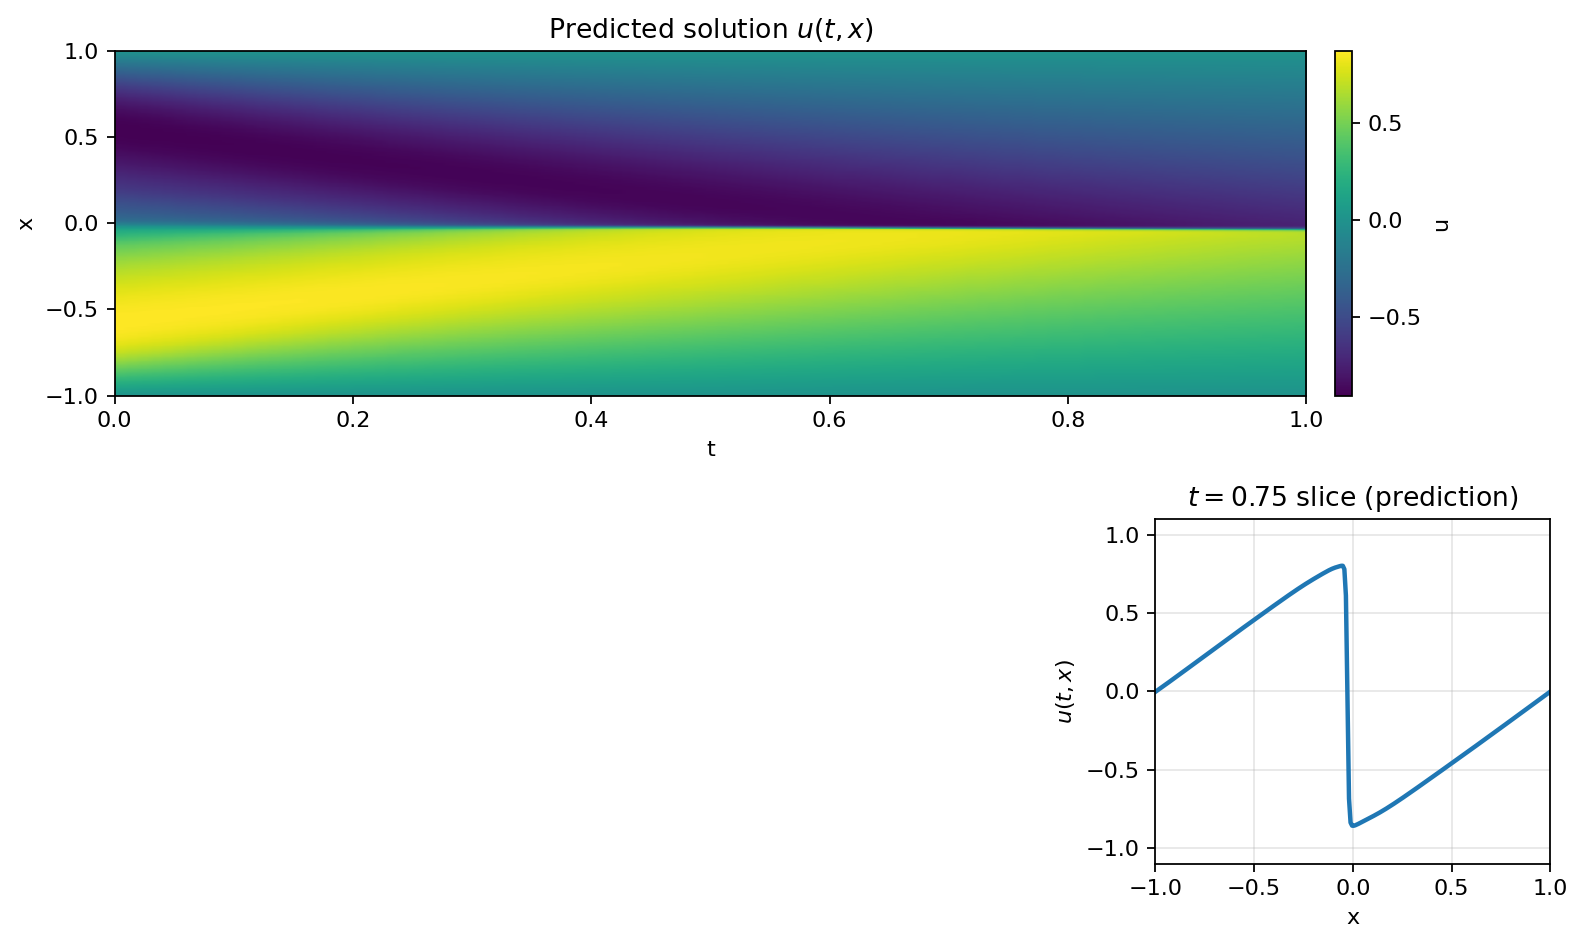

In [9]:
# Cell 7 — Plot figure like Fig A.6: top contour + rightmost slice at t=0.75 (prediction only)
fig = plt.figure(figsize=(10, 6), dpi=160)

# Top: contour (imshow)
ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=3)
im = ax1.imshow(
    U_pred,
    aspect="auto",
    origin="lower",
    extent=[tg.min(), tg.max(), xg.min(), xg.max()],
)
ax1.set_xlabel("t")
ax1.set_ylabel("x")
ax1.set_title("Predicted solution $u(t,x)$")
cbar = plt.colorbar(im, ax=ax1, pad=0.02)
cbar.set_label("u")

# Bottom-right: slice at t=0.75 (prediction only)
ax2 = plt.subplot2grid((2, 3), (1, 2))
ax2.plot(xg, u_slice_pred, linewidth=2)
ax2.set_title(r"$t=0.75$ slice (prediction)")
ax2.set_xlabel("x")
ax2.set_ylabel(r"$u(t,x)$")
ax2.set_xlim([-1, 1])
ax2.set_ylim([-1.1, 1.1])
ax2.grid(True, alpha=0.3)

# blank panels to mimic "rightmost only"
plt.subplot2grid((2, 3), (1, 0)).axis("off")
plt.subplot2grid((2, 3), (1, 1)).axis("off")

plt.tight_layout()
plt.show()
